In [1]:
import xarray as xr
import numpy as np
import datetime
import pandas as pd
from scipy import interpolate

import matplotlib as mpl
import matplotlib.pyplot as plt


import cartopy
import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr
import numpy as np

from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.animation as animation
from IPython.display import HTML

In [2]:

reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    }
}

In [3]:
## Function to crop the dataset
def Crops(coord, d_set):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by the dictionary 
        reg_ext.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """
    
    lon1, lon2 = reg_ext[coord]['lon']
    lat1, lat2 = reg_ext[coord]['lat']
    name_fig = reg_ext[coord]['name']
    
    new_ds = d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
    return(new_ds)


def Grid(data_set):
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)


def No_nan(a):
    """
        No_nan is a function that helps to filter an array from nan values.
        
        Parameters:
        ------------
        a : Numpy Array
            Is the array we want to filter
        
        Output:
        -------
        a2 : Numpy Arrray
            Array with no nan values in it
    """
    nan_array = np.isnan(a)
    not_nan_array = ~ nan_array
    a2 = a[not_nan_array]
    
    return(a2)


def Map(ax, region, xtik, ytik):
    ax.set_global()
    ax.coastlines('50m')
    ax.set_xticks(xtik, crs=ccrs.PlateCarree())
    ax.set_yticks(ytik, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.set_extent(region, crs=ccrs.PlateCarree())     #lat, lon
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
                 color='gray', alpha=0.5, linestyle='-.')



def Plot_Contours(data_set, reg, minl, maxl, nlevs, nlines, tstep=None, cmap=None):
    lon1, lon2 = reg_ext[reg]['lon']
    lat1, lat2 = reg_ext[reg]['lat']
    xtik = np.linspace(lon1, lon2, num=5)
    ytik = np.linspace(lat1, lat2, num=4)

    x_n, y_n = Grid(data_set)

    projection = ccrs.PlateCarree(360)
    region = [lon1, lon2, lat1, lat2]    #Lon, Lat
    
    if not cmap:
        cmap = 'magma_r'
    
    fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), figsize=(10,5))    
    
    Map(ax, region, xtik, ytik)
    
    if tstep==None:
        contr1 = ax.contourf(x_n, y_n, data_set.mlotst, levels=np.linspace(minl, maxl, nlevs),
                                     cmap=cmap, extend='both')
        contr2 = ax.contour(x_n, y_n, data_set.zo[0], nlines, linewidths=0.5, colors='k')
        cbar = fig.colorbar(contr1, ax=ax, shrink=0.855, orientation='vertical',
                            label='MLD [m]', extend='both')  
        #cbar.set_clim(10,120)
    else:
        contr1 = ax.contourf(x_n, y_n, data_set.mlotst[tstep], levels=np.linspace(minl, maxl, nlevs),
                                     cmap=cmap, extend='both')
        contr2 = ax.contour(x_n, y_n, data_set.zo[tstep,0], nlines, linewidths=0.5, colors='k')
        cbar = fig.colorbar(contr1, ax=ax, shrink=0.855, orientation='vertical',
                            label='MLD [m]', extend='both')  
        #cbar.set_clim(10,120)

    #fig.savefig(os.path.abspath(os.path.sep.join([".","dummy_images","Noe_%0.4d.png" % it])))
    #plt.close(fig)
    plt.show()


def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)

In [4]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################

dir_1 = '../../../New_ARMOR/'
dir_15 = '/net/krypton/data0/project/drakkar/USERS/lgarcia/data_ARMOR/'

dir_o = '/home/lgarcia/Documents/Scripts/Images_01/'

fl_n1 = 'NARMOR_*.nc'
fl_n15 = 'ARMOR_*.nc'


c_armor1 = xr.open_mfdataset(dir_1 + fl_n1, concat_dim='time')

c_armor15 = xr.open_mfdataset(dir_15 + fl_n15)
c_armor15 = Masking(c_armor15, c_armor15.to[0,25])

d1 = datetime.datetime(2005,1,1)
d2 = datetime.datetime(2018,12,20)

weeks = pd.date_range(start=d1, end=d2, freq='7D')
c_armor1.coords['time'] = (('time'), weeks)

/usr/local/lib/python3.5/dist-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/usr/local/lib/python3.5/dist-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  return self.func(self.array)
/usr/local/lib/python3.5/dist-packages/xarray/coding/times.py:132: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  enable_cftimeindex)
/usr/local/lib/python3.5/dist-packages/xarray/coding/variables.py:69: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason

# Hovmoller kind plots to observe zonal/meridional changes in time

Here the objective is to see zonal or meridional variations of the MLD in time, for one year (2005) over the Gulf Stream. I present two plots for each year, mostly due the fact that the scale difference between the summer and winter times is a 'problem' that makes difficult to appreciate the changes, if we want to see all the year at the same time. All plots are done only for MLD. 

In [79]:
reg = 'gul'
## File format :: t, lat, lon
gulf1 = Crops(reg, c_armor1)
gulf15 = Crops(reg, c_armor15)

gulf = gulf1.groupby('time.week').mean('time')

In [80]:
gulf

<xarray.Dataset>
Dimensions:    (latitude: 60, longitude: 120, week: 53)
Coordinates:
  * longitude  (longitude) float32 -74.875 -74.625 -74.375 ... -45.375 -45.125
  * latitude   (latitude) float32 30.125 30.375 30.625 ... 44.375 44.625 44.875
  * week       (week) int64 1 2 3 4 5 6 7 8 9 10 ... 45 46 47 48 49 50 51 52 53
Data variables:
    mlotst     (week, latitude, longitude) float64 dask.array<shape=(53, 60, 120), chunksize=(1, 60, 120)>

In [81]:
d1 = datetime.datetime(2000,1,1)
d2 = datetime.datetime(2000,12,31)
week2 = pd.date_range(start=d1, end=d2, freq='7D')

gulf.coords['week'] = (('week'), week2)

In [84]:
gulf

<xarray.Dataset>
Dimensions:    (latitude: 60, longitude: 120, week: 53)
Coordinates:
  * longitude  (longitude) float32 -74.875 -74.625 -74.375 ... -45.375 -45.125
  * latitude   (latitude) float32 30.125 30.375 30.625 ... 44.375 44.625 44.875
  * week       (week) datetime64[ns] 2000-01-01 2000-01-08 ... 2000-12-30
Data variables:
    mlotst     (week, latitude, longitude) float64 dask.array<shape=(53, 60, 120), chunksize=(1, 60, 120)>

## Zonal variations

### Zonal Mean MLD

In [303]:
zonal_mean = gulf.where(gulf15.mask==1).mean(dim='longitude', skipna=True)
zonal_std = gulf.where(gulf15.mask==1).std(dim='longitude', skipna=True)

part1 = zonal_mean.isel(week=slice(0,26))
part2 = zonal_mean.isel(week=slice(26, 53))

In [304]:
part1.week[::1].values

array(['2000-01-01T00:00:00.000000000', '2000-01-08T00:00:00.000000000',
       '2000-01-15T00:00:00.000000000', '2000-01-22T00:00:00.000000000',
       '2000-01-29T00:00:00.000000000', '2000-02-05T00:00:00.000000000',
       '2000-02-12T00:00:00.000000000', '2000-02-19T00:00:00.000000000',
       '2000-02-26T00:00:00.000000000', '2000-03-04T00:00:00.000000000',
       '2000-03-11T00:00:00.000000000', '2000-03-18T00:00:00.000000000',
       '2000-03-25T00:00:00.000000000', '2000-04-01T00:00:00.000000000',
       '2000-04-08T00:00:00.000000000', '2000-04-15T00:00:00.000000000',
       '2000-04-22T00:00:00.000000000', '2000-04-29T00:00:00.000000000',
       '2000-05-06T00:00:00.000000000', '2000-05-13T00:00:00.000000000',
       '2000-05-20T00:00:00.000000000', '2000-05-27T00:00:00.000000000',
       '2000-06-03T00:00:00.000000000', '2000-06-10T00:00:00.000000000',
       '2000-06-17T00:00:00.000000000', '2000-06-24T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [305]:
part2.week[::1].values

array(['2000-07-01T00:00:00.000000000', '2000-07-08T00:00:00.000000000',
       '2000-07-15T00:00:00.000000000', '2000-07-22T00:00:00.000000000',
       '2000-07-29T00:00:00.000000000', '2000-08-05T00:00:00.000000000',
       '2000-08-12T00:00:00.000000000', '2000-08-19T00:00:00.000000000',
       '2000-08-26T00:00:00.000000000', '2000-09-02T00:00:00.000000000',
       '2000-09-09T00:00:00.000000000', '2000-09-16T00:00:00.000000000',
       '2000-09-23T00:00:00.000000000', '2000-09-30T00:00:00.000000000',
       '2000-10-07T00:00:00.000000000', '2000-10-14T00:00:00.000000000',
       '2000-10-21T00:00:00.000000000', '2000-10-28T00:00:00.000000000',
       '2000-11-04T00:00:00.000000000', '2000-11-11T00:00:00.000000000',
       '2000-11-18T00:00:00.000000000', '2000-11-25T00:00:00.000000000',
       '2000-12-02T00:00:00.000000000', '2000-12-09T00:00:00.000000000',
       '2000-12-16T00:00:00.000000000', '2000-12-23T00:00:00.000000000',
       '2000-12-30T00:00:00.000000000'], dtype='dat

In [306]:
n = xr.concat([part2, part1], dim='week')

print(n.week.values)

a = pd.to_datetime(n.week.values)


['2000-07-01T00:00:00.000000000' '2000-07-08T00:00:00.000000000'
 '2000-07-15T00:00:00.000000000' '2000-07-22T00:00:00.000000000'
 '2000-07-29T00:00:00.000000000' '2000-08-05T00:00:00.000000000'
 '2000-08-12T00:00:00.000000000' '2000-08-19T00:00:00.000000000'
 '2000-08-26T00:00:00.000000000' '2000-09-02T00:00:00.000000000'
 '2000-09-09T00:00:00.000000000' '2000-09-16T00:00:00.000000000'
 '2000-09-23T00:00:00.000000000' '2000-09-30T00:00:00.000000000'
 '2000-10-07T00:00:00.000000000' '2000-10-14T00:00:00.000000000'
 '2000-10-21T00:00:00.000000000' '2000-10-28T00:00:00.000000000'
 '2000-11-04T00:00:00.000000000' '2000-11-11T00:00:00.000000000'
 '2000-11-18T00:00:00.000000000' '2000-11-25T00:00:00.000000000'
 '2000-12-02T00:00:00.000000000' '2000-12-09T00:00:00.000000000'
 '2000-12-16T00:00:00.000000000' '2000-12-23T00:00:00.000000000'
 '2000-12-30T00:00:00.000000000' '2000-01-01T00:00:00.000000000'
 '2000-01-08T00:00:00.000000000' '2000-01-15T00:00:00.000000000'
 '2000-01-22T00:00:00.000

In [307]:
months = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 
          'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', ]

In [308]:
 n.latitude.values

l = [ lat for lat in n.latitude.values]

<IPython.core.display.Javascript object>


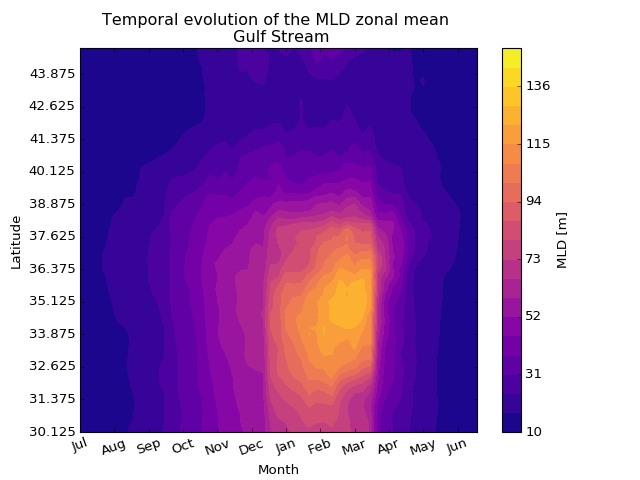

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


In [322]:
%matplotlib notebook

plt.close()

x = pd.to_datetime(n.week.values)
y =  n.latitude.values
#X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots()

cs = ax.contourf(n.mlotst.T, levels=np.linspace(10., 150., 21), cmap='plasma')
#ax.set_xlabel('time [weeks]')
#ax.set_ylabel('MLD [m]')
#ax.set_title('Gulf Stream MLD distribution')
cb = fig.colorbar(cs, ax=ax, orientation='vertical')

plt.xticks(np.arange(n.week.size, step=4.5), months, rotation=20)
plt.yticks(np.arange(len(l), step=5), l[::5])

plt.xlabel('Month')
plt.ylabel('Latitude')

plt.title('Temporal evolution of the MLD zonal mean \n Gulf Stream')

cb.set_label('MLD [m]')
plt.savefig(dir_o + 'Gul-PDF-Seasonal-Hov.png')
plt.show()

### Zonal standar deviation

In [12]:
zonal_std = gulf.std(dim='longitude')

/venv/py3-phyocean/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


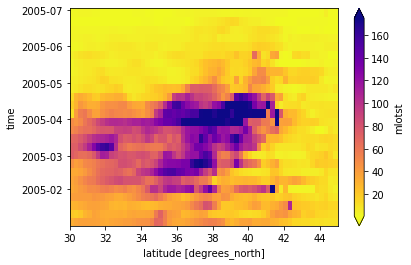

In [13]:
zonal_std.mlotst.sel(time=slice('2005-01', '2005-06')).plot(cmap='plasma_r', robust=True)

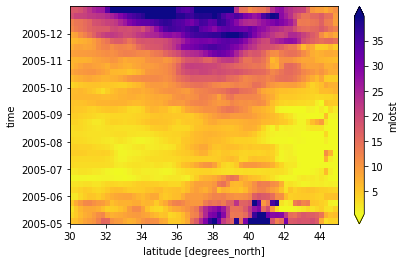

In [14]:
zonal_std.mlotst.sel(time=slice('2005-05', '2005-12')).plot(cmap='plasma_r', robust=True)

## Meridional variations

### Meridional mean

In [316]:
merid_mean = gulf.where(gulf15.mask==1).mean(dim='latitude', skipna=True)
merid_std = gulf.where(gulf15.mask==1).std(dim='latitude', skipna=True)

part1 = merid_mean.isel(week=slice(0,26))
part2 = merid_mean.isel(week=slice(26, 53))

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<IPython.core.display.Javascript object>


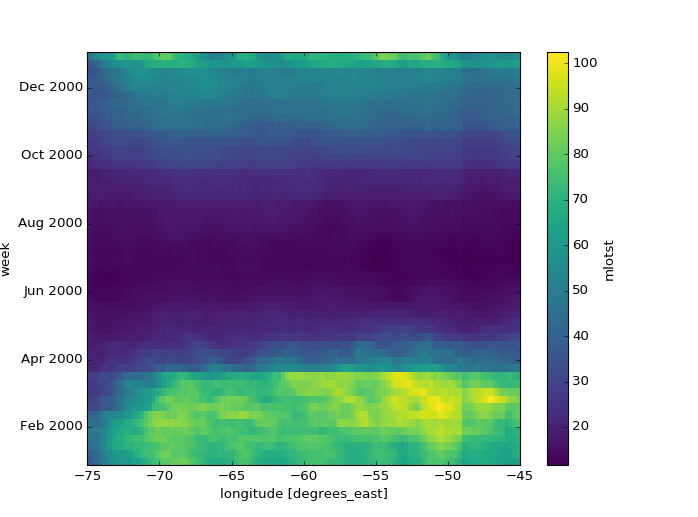

In [321]:
plt.close()
merid_mean.mlotst.plot()
plt.show()


In [317]:
part1.week[::1].values

array(['2000-01-01T00:00:00.000000000', '2000-01-08T00:00:00.000000000',
       '2000-01-15T00:00:00.000000000', '2000-01-22T00:00:00.000000000',
       '2000-01-29T00:00:00.000000000', '2000-02-05T00:00:00.000000000',
       '2000-02-12T00:00:00.000000000', '2000-02-19T00:00:00.000000000',
       '2000-02-26T00:00:00.000000000', '2000-03-04T00:00:00.000000000',
       '2000-03-11T00:00:00.000000000', '2000-03-18T00:00:00.000000000',
       '2000-03-25T00:00:00.000000000', '2000-04-01T00:00:00.000000000',
       '2000-04-08T00:00:00.000000000', '2000-04-15T00:00:00.000000000',
       '2000-04-22T00:00:00.000000000', '2000-04-29T00:00:00.000000000',
       '2000-05-06T00:00:00.000000000', '2000-05-13T00:00:00.000000000',
       '2000-05-20T00:00:00.000000000', '2000-05-27T00:00:00.000000000',
       '2000-06-03T00:00:00.000000000', '2000-06-10T00:00:00.000000000',
       '2000-06-17T00:00:00.000000000', '2000-06-24T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [318]:
part2.week[::1].values

array(['2000-07-01T00:00:00.000000000', '2000-07-08T00:00:00.000000000',
       '2000-07-15T00:00:00.000000000', '2000-07-22T00:00:00.000000000',
       '2000-07-29T00:00:00.000000000', '2000-08-05T00:00:00.000000000',
       '2000-08-12T00:00:00.000000000', '2000-08-19T00:00:00.000000000',
       '2000-08-26T00:00:00.000000000', '2000-09-02T00:00:00.000000000',
       '2000-09-09T00:00:00.000000000', '2000-09-16T00:00:00.000000000',
       '2000-09-23T00:00:00.000000000', '2000-09-30T00:00:00.000000000',
       '2000-10-07T00:00:00.000000000', '2000-10-14T00:00:00.000000000',
       '2000-10-21T00:00:00.000000000', '2000-10-28T00:00:00.000000000',
       '2000-11-04T00:00:00.000000000', '2000-11-11T00:00:00.000000000',
       '2000-11-18T00:00:00.000000000', '2000-11-25T00:00:00.000000000',
       '2000-12-02T00:00:00.000000000', '2000-12-09T00:00:00.000000000',
       '2000-12-16T00:00:00.000000000', '2000-12-23T00:00:00.000000000',
       '2000-12-30T00:00:00.000000000'], dtype='dat

In [306]:
n = xr.concat([part2, part1], dim='week')

print(n.week.values)

a = pd.to_datetime(n.week.values)


['2000-07-01T00:00:00.000000000' '2000-07-08T00:00:00.000000000'
 '2000-07-15T00:00:00.000000000' '2000-07-22T00:00:00.000000000'
 '2000-07-29T00:00:00.000000000' '2000-08-05T00:00:00.000000000'
 '2000-08-12T00:00:00.000000000' '2000-08-19T00:00:00.000000000'
 '2000-08-26T00:00:00.000000000' '2000-09-02T00:00:00.000000000'
 '2000-09-09T00:00:00.000000000' '2000-09-16T00:00:00.000000000'
 '2000-09-23T00:00:00.000000000' '2000-09-30T00:00:00.000000000'
 '2000-10-07T00:00:00.000000000' '2000-10-14T00:00:00.000000000'
 '2000-10-21T00:00:00.000000000' '2000-10-28T00:00:00.000000000'
 '2000-11-04T00:00:00.000000000' '2000-11-11T00:00:00.000000000'
 '2000-11-18T00:00:00.000000000' '2000-11-25T00:00:00.000000000'
 '2000-12-02T00:00:00.000000000' '2000-12-09T00:00:00.000000000'
 '2000-12-16T00:00:00.000000000' '2000-12-23T00:00:00.000000000'
 '2000-12-30T00:00:00.000000000' '2000-01-01T00:00:00.000000000'
 '2000-01-08T00:00:00.000000000' '2000-01-15T00:00:00.000000000'
 '2000-01-22T00:00:00.000

In [307]:
months = ['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 
          'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', ]

In [308]:
 n.latitude.values

l = [ lat for lat in n.latitude.values]

<IPython.core.display.Javascript object>


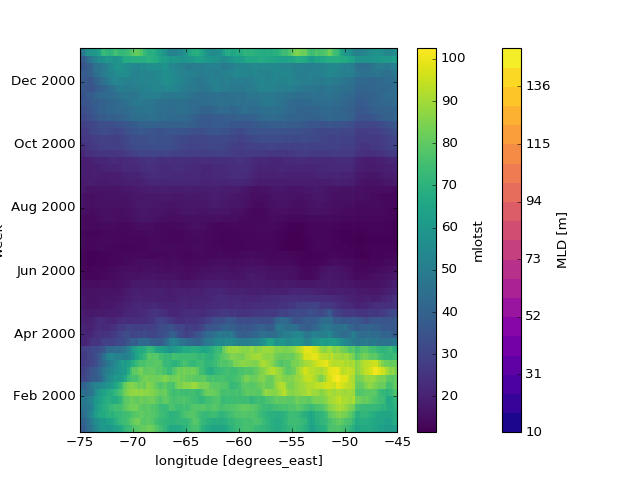

/usr/local/lib/python3.5/dist-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


In [319]:
%matplotlib notebook

plt.close()

x = pd.to_datetime(n.week.values)
y =  n.latitude.values
#X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots()

cs = ax.contourf(merid_mean.mlotst, levels=np.linspace(10., 150., 21), cmap='plasma')
#ax.set_xlabel('time [weeks]')
#ax.set_ylabel('MLD [m]')
#ax.set_title('Gulf Stream MLD distribution')
cb = fig.colorbar(cs, ax=ax, orientation='vertical')

#plt.xticks(np.arange(n.week.size, step=4.5), months, rotation=20)
#plt.yticks(np.arange(len(l), step=5), l[::5])

#plt.xlabel('Month')
#plt.ylabel('Latitude')

plt.title('Temporal evolution of the MLD meridional mean \n Gulf Stream')

cb.set_label('MLD [m]')

plt.show()

In [15]:
merid_mean = gulf.mean(dim='latitude')

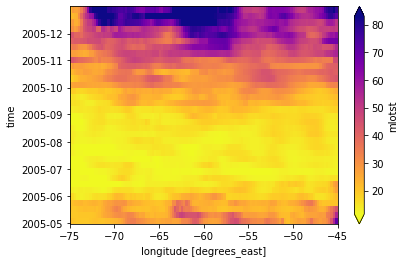

In [16]:
merid_mean.mlotst.sel(time=slice('2005-05', '2005-12')).plot(cmap='plasma_r', robust=True)

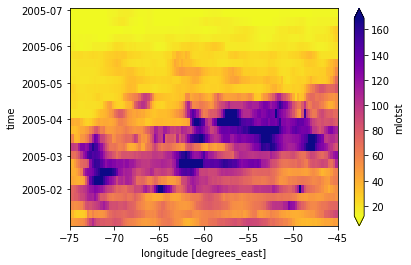

In [17]:
merid_mean.mlotst.sel(time=slice('2005-01', '2005-06')).plot(cmap='plasma_r', robust=True)

### Meridional standar deviation

In [18]:
merid_std = gulf.std(dim='latitude')

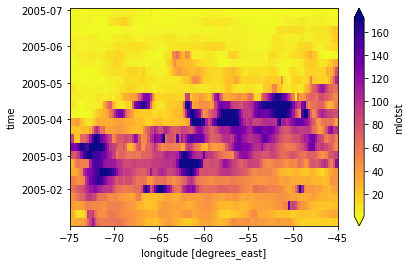

In [19]:
merid_std.mlotst.sel(time=slice('2005-01', '2005-06')).plot(cmap='plasma_r', robust=True)

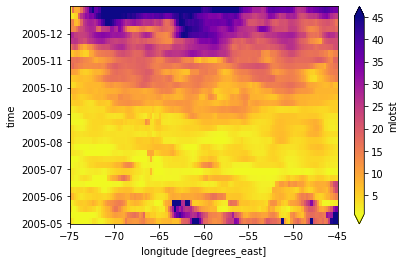

In [20]:
merid_std.mlotst.sel(time=slice('2005-05', '2005-12')).plot(cmap='plasma_r', robust=True)